<a href="https://colab.research.google.com/github/sauddy/DPCNet/blob/main/DPCNet_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DPCNet_Build -- 26 November  2020 Colab Compatible

In [1]:
## Please note this version of the code is compatible with Google colab and will also run on Local Computer ## 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
                           ##### IDEA Behind this notebook : ###########
## Author : Sayantan 
## Created : 26 November 2020
## This notebook is adopted from the CNN_DPNNet V3 and V5
## CNN modules, RESNET50, ALEXNET, VGG16 are implemented by Ramit Dey



## The primary idea is to develop a modular notebook that does the following:
## Import all the customized Modules from Modules_DPCNet 
## For data processing use data_processing.py
## A function module to call the different networks independently. (deep_models.py, other_cnn.py)


In [3]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os

## Modules to check the performance of the code
from time import process_time 
!pip install memory_profiler ## When running from Google Colab
import memory_profiler as mem_profile
print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score



  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp36-none-any.whl size=30181 sha256=7510d8ba6aa4d5dd9f6b432236f2b72b43a40260992473e1c0fa375f16711767
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler
Memory (Before): [123.48046875]Mb


In [4]:
############ Please provide the same path to the code directory if using Colab################

Path_gdrive= '/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPCNet
import sys
try: ## tries to find the modules in the local directory first
  path ='' # For local computer  
  sys.path.append(path+'MODULES_DPCNeT')
  import data_processing as dp
  import deep_models as dm
  import other_cnns as ocn

  ########### Folders to save the processed data, files and figures when using Local computer ##############
  !mkdir -p data_folder
  !mkdir -p figures ## to save the figurs
  !mkdir -p saved_model
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path =Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPCNeT')
    import data_processing as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figurs
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")



/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/
We are currently using the Modules_DPCNet
Creating the folders
[INFO] Modules imported


In [5]:
# ########### Folders to save the process data, files and figures when using GDRIVE ##############

# import os
# os.chdir(Path_gdrive)
# !mkdir -p data_folder
# !mkdir -p figures ## to save the figurs
# !mkdir -p figures_paper
# !mkdir -p saved_model

# ########### Folders to save the process data, files and figures when using Local computer ##############
# # !mkdir -p data_folder
# # !mkdir -p figures ## to save the figurs
# # !mkdir -p saved_model

## Load data csv (including the path to images) from multiple time-instances

In [6]:
############# Address to the data folder ###################
list_of_orbits = ['150','140','130','120']

print("[INFO]: Importing files from the datafolder")
## Note the data folder are a directory above the code directory
folder_address = path + "../analysis_output_"
# folder_address = "/content/drive/MyDrive/CNN_DPNNET/analysis_output_" 
# The idea is to generate a dataframe with the parameters and the path to the images
data_complete = dp.parse_time_series_data(folder_address,list_of_orbits,path)




[INFO]: Importing files from the datafolder
[INFO] preparing the dataframe from differnt times...
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_150/
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_140/
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_130/
Reading the image paths and data from folder: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/../analysis_output_120/
[INFO] The concatination of dataframes from differnt times are now complete


## Preparing data 

In [7]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split
## Save the train and the test data for future use as well.

test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path)


#### Desired Image resoltuion #####
X_res = Y_res = 128

## Generate the training and the test images 

trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('Memory (After Loading): {}Mb'.format(mem_profile.memory_usage()))
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each chategory



[INFO] preparing the normalized data training/testing split...
[INFO] Done...
[INFO] Loading images from Train data..
Train Images are loaded
[INFO] Loading images from Test data..
Test Images are loaded
Memory (After Loading): [628.59765625]Mb
There are 2128 Train, 375 Validation and 442 Test images


## Training the CNN 

In [8]:
## Hyper-Parameter to define
batch_size = 20 ## the best was for 200 last run
valid_batch_size = 20
epochs=200 ## best was 100
init_lr = 1e-5

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=20, verbose=1, mode='min',restore_best_weights=True)



In [9]:
## Select the Network type

# NETWORK = "Vanilla"
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
NETWORK = "RESNET50"

print('INFO: Currently training using the {} NETWORK'.format(NETWORK))
if NETWORK == "Vanilla":
    CNN = dm.build_cnn(X_res, Y_res, 3, regress=True)
elif NETWORK == "ALEXNET":
    CNN = ocn.alexnet(X_res, Y_res, 3, regress=True)
elif NETWORK == "VGG":
    CNN = ocn.cnn_vgg(X_res, Y_res, 3, regress=True)
elif NETWORK == "RESNET50":
    CNN = ocn.ResNet50(X_res, Y_res, 3)
# optimizer = tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/2000)
CNN.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mean_absolute_error', 'mean_squared_error'])
CNN_history = CNN.fit(x=trainImagesX, y=train_labels,
                  validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])
print('Memory (After Training): {}Mb'.format(mem_profile.memory_usage()))

INFO: Currently training using the RESNET50 NETWORK
Epoch 1/200
107/107 [==============================] - 8s 71ms/step - loss: 2438.6128 - mean_absolute_error: 41.1190 - mean_squared_error: 2438.6128 - val_loss: 5801.6660 - val_mean_absolute_error: 70.2159 - val_mean_squared_error: 5801.6660
Epoch 2/200
107/107 [==============================] - 6s 60ms/step - loss: 791.9426 - mean_absolute_error: 23.7337 - mean_squared_error: 791.9425 - val_loss: 3943.9375 - val_mean_absolute_error: 55.8708 - val_mean_squared_error: 3943.9375
Epoch 3/200
107/107 [==============================] - 6s 60ms/step - loss: 608.0038 - mean_absolute_error: 20.5485 - mean_squared_error: 608.0038 - val_loss: 1933.6821 - val_mean_absolute_error: 37.4713 - val_mean_squared_error: 1933.6821
Epoch 4/200
107/107 [==============================] - 6s 60ms/step - loss: 446.5681 - mean_absolute_error: 17.1778 - mean_squared_error: 446.5681 - val_loss: 677.3270 - val_mean_absolute_error: 21.6299 - val_mean_squared_erro

/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/figures


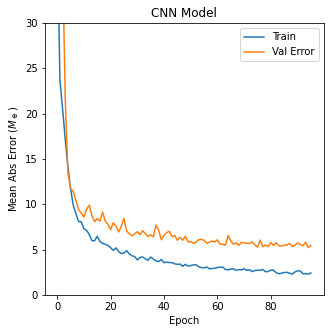

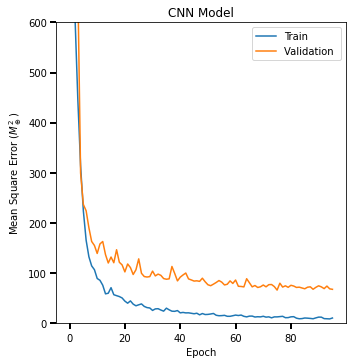

In [10]:
## The plots for the Validation and the Testing loss
dp.plot_history(CNN_history,path, Model = "CNN")
hist_df = pd.DataFrame(CNN_history.history)  ## converting to dataframe
## Saving the history
hist_df.to_csv(path+'data_folder/'+NETWORK+'_history.csv')

## Saving the network for future use

In [11]:
## uncomment the following lines if you want to update your model
CNN.save(path+'saved_model/'+NETWORK+'_model')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/saved_model/RESNET50_model/assets


In [12]:
## Loading the model
CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_model')
##Check its architecture
CNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 4736        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

## Model Evaluation for DPCNet

In [13]:
loss, mae, mse = CNN.evaluate(testImagesX, test_labels, verbose=0)
print("Testing set Mean Square Error for {}: {:5.2f} ".format(NETWORK,mse))
print("Testing set Root Mean Square Error for {}: {:5.2f} M_Earth".format( NETWORK,np.sqrt(mse)))
print("Testing set Mean Abs Error for {} : {:5.2f} M_Earth ".format(NETWORK,mae))
print("Testing set Loss for {}: {:5.2f} M_Earth".format(NETWORK,loss))

Testing set Mean Square Error for RESNET50: 86.23 
Testing set Root Mean Square Error for RESNET50:  9.29 M_Earth
Testing set Mean Abs Error for RESNET50 :  5.83 M_Earth 
Testing set Loss for RESNET50: 86.23 M_Earth


## Implementing the hybrid model, i.e., DPCNet + DPNNet##

In [14]:
DPNNet = dm.DPNNet_build(normed_train_data.shape[1], regress=False)



if NETWORK == "Vanilla":
    CNN_ = dm.build_cnn(X_res, Y_res, 3, regress=False)
elif NETWORK == "ALEXNET":
    CNN_ = ocn.alexnet(X_res, Y_res, 3, regress=False)
elif NETWORK == "VGG":
    CNN_ = ocn.cnn_vgg(X_res, Y_res, 3, regress=False)
elif NETWORK == "RESNET50":
    CNN_ = ocn.ResNet50(X_res, Y_res, 3)

combinedInput = concatenate([DPNNet.output,CNN_.output])
# our final FC layer head will have two dense layers, the final one being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)



## Training the Hybrid Model (DPCNet + DPNNet)

In [15]:
epochs=200 ## best was 100
init_lr = 1e-4
hybrid_model = Model(inputs=[DPNNet.input, CNN_.input], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr_schedule)
optimizer = tf.keras.optimizers.Adam(init_lr,decay=init_lr /200) #, 
hybrid_model.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mean_absolute_error', 'mean_squared_error'])
print('INFO: Currently training using the {} NETWORK and DPNNet'.format(NETWORK))
history_hybrid = hybrid_model.fit(x=[normed_train_data, trainImagesX], y=train_labels,
    validation_split = 0.15,verbose=1,
    epochs=epochs, batch_size=batch_size,callbacks=[early_stop])


INFO: Currently training using the RESNET50 NETWORK and DPNNet
Epoch 1/200
107/107 [==============================] - 8s 71ms/step - loss: 1702.3512 - mean_absolute_error: 32.3926 - mean_squared_error: 1702.3320 - val_loss: 5180.4722 - val_mean_absolute_error: 65.6514 - val_mean_squared_error: 5180.4536
Epoch 2/200
107/107 [==============================] - 7s 64ms/step - loss: 271.9387 - mean_absolute_error: 12.9137 - mean_squared_error: 271.9200 - val_loss: 4264.1602 - val_mean_absolute_error: 58.6740 - val_mean_squared_error: 4264.1421
Epoch 3/200
107/107 [==============================] - 7s 67ms/step - loss: 151.7847 - mean_absolute_error: 9.5326 - mean_squared_error: 151.7661 - val_loss: 2020.9904 - val_mean_absolute_error: 39.3759 - val_mean_squared_error: 2020.9720
Epoch 4/200
107/107 [==============================] - 7s 64ms/step - loss: 134.8526 - mean_absolute_error: 9.0636 - mean_squared_error: 134.8340 - val_loss: 395.1384 - val_mean_absolute_error: 16.2007 - val_mean_squ

/content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/figures


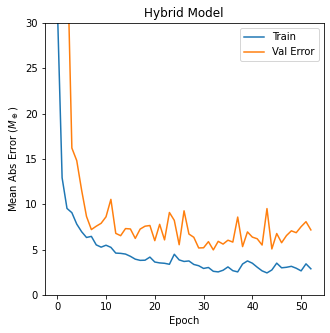

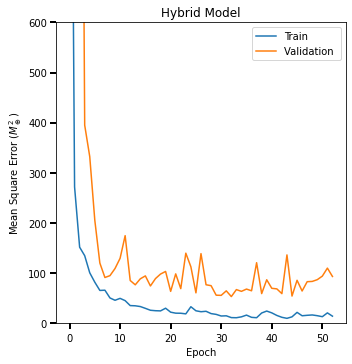

In [16]:
dp.plot_history(history_hybrid,path, Model = "Hybrid")
hist_hybrid = pd.DataFrame(history_hybrid.history) 
hist_hybrid.to_csv(path+'data_folder/'+NETWORK+'history_hybrid.csv')

In [17]:

hybrid_model.save(path+'saved_model/'+NETWORK+'_hybrid_model') 
# hybrid_model = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'hybrid_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN_DPNNET/DPCNET_dev/saved_model/RESNET50_hybrid_model/assets


## Model Evaluation for Hybrid Model

In [18]:
loss, mae, mse = hybrid_model.evaluate([normed_test_data,testImagesX], test_labels, verbose=0)
print("Testing set Mean Square Error for {} with DPNNet: {:5.2f} ".format(NETWORK,mse))
print("Testing set Root Mean Square Error for {} with DPNNet: {:5.2f} M_Earth".format( NETWORK,np.sqrt(mse)))
print("Testing set Mean Abs Error for {} with DPNNet: {:5.2f} M_Earth ".format(NETWORK,mae))
print("Testing set Loss for {} with DPNNet: {:5.2f} M_Earth".format(NETWORK,loss))

Testing set Mean Square Error for RESNET50 with DPNNet: 67.59 
Testing set Root Mean Square Error for RESNET50 with DPNNet:  8.22 M_Earth
Testing set Mean Abs Error for RESNET50 with DPNNet:  5.18 M_Earth 
Testing set Loss for RESNET50 with DPNNet: 67.61 M_Earth


## Model Predictions and Results

In [19]:
pred_CNN = CNN.predict(testImagesX)
np.shape(pred_CNN)

pred_Hybird = hybrid_model.predict([normed_test_data,testImagesX])
np.shape(pred_Hybird)

(442, 1)

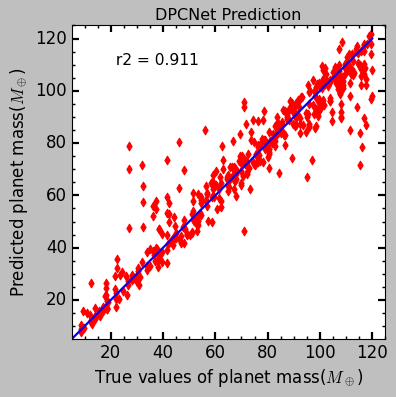

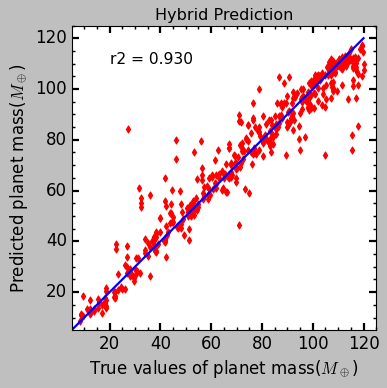

In [20]:
plt.style.use('classic')
plt.figure(figsize = (5,5))
# test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels,pred_CNN.flatten(),s=30,marker='d',color='r')

score_CNN = r2_score(test_labels,pred_CNN.flatten())
plt.text(20,110,r" r2 = {:.3f}".format(score_CNN), fontsize =14)
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.title("DPCNet Prediction")
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)

# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2)
plt.minorticks_on() 
plt.tight_layout()
plt.savefig(path+'figures/predicted_correlation_CNN.pdf',format='pdf',dpi=300)

plt.tick_params(labelsize=15)

plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.figure(figsize = (5,5))
score_HYBRID = r2_score(test_labels,pred_Hybird.flatten())
plt.text(20,110,r"r2 = {:.3f}".format(score_HYBRID),fontsize =14)
plt.scatter(test_labels,pred_Hybird.flatten(),s=20,marker='d',color='r')
plt.title("Hybrid Prediction")
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)

# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2)

plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
plt.savefig(path+'figures/predicted_correlation_hybrid.pdf',format='pdf',dpi=300)
# print("{} r2 score is {}".format(NETWORK,score_CNN))
# print("{} + DPPNET r2 score is {}".format(NETWORK,score_HYBRID))